In [1]:
# TODO:  


In [21]:
%pylab inline
import biff
#import coefficients_smoothing
sys.path.append('../code/')
from mwlmc_bfe import smooth_coeff
import kinematics

from astropy import units as u
import astropy.coordinates as coord

Populating the interactive namespace from numpy and matplotlib


In [192]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [19]:
# Compute acceleration grid in cartessian coordinates
# Transfor to galactic coordinates

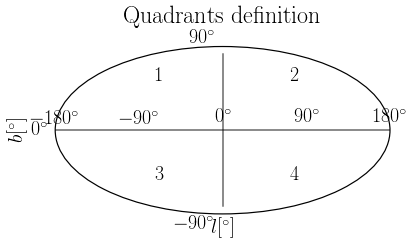

In [18]:
#fig = plt.figure(figsize=(6,6))


fig  = plt.subplot(1,1,1, projection='mollweide')
title('Quadrants definition', y=1.1)
fig.axhline(0, c='k', alpha=0.6)
fig.axvline(0, c='k', alpha=0.6)
#fig.axvline(-np.pi/2., c='k', alpha=0.6)
#fig.axvline(np.pi/2., c='k', alpha=0.6)

fig.text(-np.pi/2, np.pi/4, '1')
fig.text(np.pi/2, np.pi/4, '2')
fig.text(-np.pi/2, -np.pi/4, '3')
fig.text(np.pi/2, -np.pi/4, '4')



xlabel('$l[^{\circ}]$')
ylabel('$b[^{\circ}]$')
xticks([-np.pi, -np.pi/2., 0, np.pi/2., np.pi])
yticks([-np.pi/2., 0, np.pi/2.])

savefig('octants_def.pdf', bbox_inches='tight')

In [596]:
def spherical_grid(n_points, rmin, rmax):
    phi = np.linspace(0, 2*np.pi, n_points)
    arccos = np.linspace(-1, 1, n_pointd)
    theta = np.arccos(arccos)
    
    rmin = (rmin/3.)**3.
    rmax = (rmax/3.)**3.

    r = 3*(np.linspace(rmin, rmax, n_points/3.))**(1/3.)
    x = r * sin(theta)*cos(phi) 
    y = r * sin(theta)*sin(phi) 
    z = r * cos(theta) 

    return np.ascontiguousarray(np.array([x, y, z]).T)

def octant_grid(n_points, rmin, rmax, octant):
    phi = np.random.rand(n_points)*2*np.pi
    arccos = (np.random.rand(n_points)*2 - 1)
    
    rmin = (rmin/3.)**3.
    rmax = (rmax/3.)**3.
    
    if octant==4:
        index = np.where((phi<np.pi/2.) & (arccos>0))[0]
    elif octant==3:
        index = np.where((phi<np.pi) & (phi>np.pi/2.) & (arccos>0))[0]
    elif octant==2:
        index = np.where((phi<3*np.pi/2.) & (phi>np.pi) & (arccos>0))[0]
    elif octant==1:
        index = np.where((phi<2*np.pi) & (phi>3*np.pi/2.) & (arccos>0))[0]
    elif octant==8:
        index = np.where((phi<np.pi/2.) & (arccos<0))[0]
    elif octant==7:
        index = np.where((phi<np.pi) & (phi>np.pi/2.) & (arccos<0))[0]
    elif octant==6:
        index = np.where((phi<3*np.pi/2.) & (phi>np.pi) & (arccos<0))[0]
    elif octant==5:
        index = np.where((phi<2*np.pi) & (phi>3*np.pi/2.) & (arccos<0))[0]
    else:
        index=np.arange(0, len(phi),1)
    theta = np.arccos(arccos[index])
    phi = phi[index]
        
    r = 3*(np.random.rand(len(index))*(rmax-rmin) + rmin)**(1/3.)
    x = r * sin(theta)*cos(phi) 
    y = r * sin(theta)*sin(phi) 
    z = r * cos(theta) 

    return np.ascontiguousarray(np.array([x, y, z]).T)

def cuadrant_grid(n_points, rmin, rmax, cuadrant):
    phi = np.random.rand(n_points)*2*np.pi
    arccos = (np.random.rand(n_points)*2 - 1)
    
    rmin = (rmin/3.)**3.
    rmax = (rmax/3.)**3.

 
    if cuadrant==1:
        index = np.where((phi<2*np.pi) & (phi>np.pi) & (arccos>0))[0]
    elif cuadrant==2:
        index = np.where((phi<np.pi)  & (arccos>0))[0]
    elif cuadrant==3:
        index = np.where((phi<2*np.pi) & (phi>np.pi) & (arccos<0))[0]
    elif cuadrant==4:
        index = np.where((phi<np.pi)  & (arccos<0))[0]

    else:
        index=np.arange(0, len(phi),1)
    theta = np.arccos(arccos[index])
    phi = phi[index]
        
    r = 3*(np.random.rand(len(index))*(rmax-rmin) + rmin)**(1/3.)
    x = r * sin(theta)*cos(phi) 
    y = r * sin(theta)*sin(phi) 
    z = r * cos(theta) 

    return np.ascontiguousarray(np.array([x, y, z]).T)

def spherical_grid_shift(xyz, shift_com):
    x_shift = xyz[:,0] - shift_com[0]
    y_shift = xyz[:,1] - shift_com[1]
    z_shift = xyz[:,2] - shift_com[2]
    return np.ascontiguousarray(np.array([x_shift, y_shift, z_shift]).T)

def eval_bfe_spherical_grid(n_points, rmin, rmax, dr, S1, T1, rs, S2=0, T2=0, shift=0, octant=0, M=1):
    G_gadget = 43007.1
    r = np.arange(rmin, rmax, dr)
    n_points_shell = int(n_points/(len(r)-1))
    ax_r = np.zeros(len(r))
    ay_r = np.zeros(len(r))
    az_r = np.zeros(len(r))
    a_r1 = np.zeros(len(r))
    a_r2 = np.zeros(len(r))
    #print(octant)
    n_points_r = np.zeros(len(r))
    for i in range(len(r)-1):
        #xyz = octant_grid(n_points, r[i], r[i+1], octant)
        xyz = cuadrant_grid(n_points, r[i], r[i+1], octant)

        if shift==1:
            xyz = spherical_grid_shift(xyz, [-1.6172733999999993, -41.39907439, -27.93125875])
            
        a1 = biff.gradient(xyz, S1, T1, G=G_gadget, M=1, r_s=rs)
        a_r1[i] = np.median(np.sqrt(a1[:,0]**2+ a1[:,1]**2 + a1[:,2]**2))
      
    #if type(S2) != int:
    #    a2 = biff.gradient(xyz, S2, T2, rs, M=M)
    #    a_r2[i] = np.median(np.sqrt(a2[:,0]**2+ a2[:,1]**2 + a2[:,2]**2))
    #r2 = np.sqrt(xyz[:,0]**2 + xyz[:,1]**2 + xyz[:,2]**2)
    return r, a_r1

In [491]:
l4 = np.linspace(-180, 180, 200)
b4 = np.linspace(-90, 90, 100)
L4, B4 = np.meshgrid(l4, b4)
Q4 = coord.Galactocentric(lon=L4*u.deg, lat=B4*u.deg, distance=50*u.kpc, representation='spherical')
c1 = Q4.cartesian
xyz = np.ascontiguousarray(np.array([c1.x.flatten(), c1.y.flatten(), c1.z.flatten()]).T)


In [598]:
xyz_shift = spherical_grid_shift(xyz, [-1.6172733999999993, -41.39907439, -27.93125875])

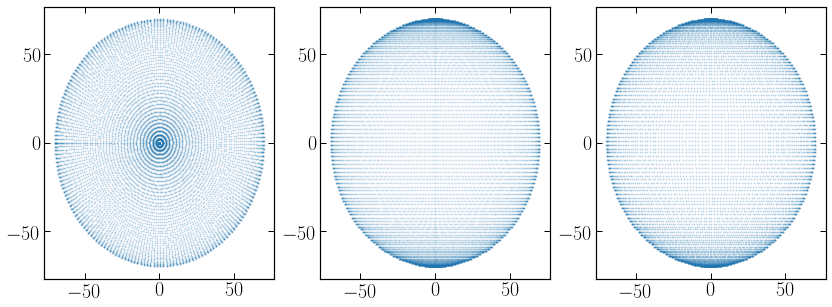

In [480]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

#ax[0].scatter(-8.2, 0, c='k', s=60)
ax[0].scatter(c1.x, c1.y, alpha=0.1, s=1)

#ax[1].scatter(-8.2, 0, c='k', s=60)
ax[1].scatter(c1.y, c1.z, alpha=0.1, s=1)


ax[2].scatter(c1.x, c1.z, alpha=0.1, s=1)


In [330]:
#Cuadrant4 = kinematics.Kinematics(xyz, xyz)

In [359]:
#l, b = Cuadrant4.pos_cartesian_to_galactic()

In [360]:
#l4 = np.linspace(0, 180, 100)
#b4 = np.linspace(-90, 0, 100)
#L4, B4 = np.meshgrid(l4, b4)

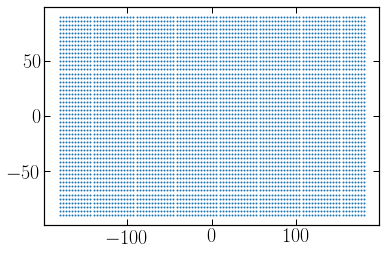

In [333]:
scatter(L4, B4, s=1)

In [629]:
covmat_lmc_path = '../data/interim/BFE/MWLMC3/bfe_LMC3_bound_b0_covmat_sample_'
coeff_lmc_path = '../data/interim/BFE/MWLMC3/bfe_LMC3_bound_b0_coeff_sample_'

covmat_mw_path = '../data/interim/BFE/MWLMC3/bfe_MW_81_MWLMC3_bound_b1_covmat_sample_'
coeff_mw_path =  '../data/interim/BFE/MWLMC3/bfe_MW_81_MWLMC3_bound_b1_coeff_sample_'

covmat_mwlmc_path = '../data/interim/BFE/MWLMC3/bfe_MWLMC_unbound_81_MWLMC3_100M_new_b1_covmat_sample_'
coeff_mwlmc_path =  '../data/interim/BFE/MWLMC3/bfe_MWLMC_unbound_81_MWLMC3_100M_new_b1_coeff_sample_'

mass = 1.577212515257997438e-06


In [630]:
S_mw, T_mw, N_mw = smooth_coeff(coeff_mw_path, covmat_mw_path, 0, 9, 20, 20, 20, 6, mass, snap=90, sn_out=0)
S_lmc, T_lmc, N_lmc = smooth_coeff(coeff_lmc_path, covmat_lmc_path, 0, 9, 20, 20, 20, 6, mass, snap=90, sn_out=0)
S_mwlmc, T_mwlmc, N_mwlmc = smooth_coeff(coeff_lmc_path, covmat_lmc_path, 0, 9, 20, 20, 20, 6, mass, snap=90, sn_out=0)


../code/coefficients_smoothing.py:100: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


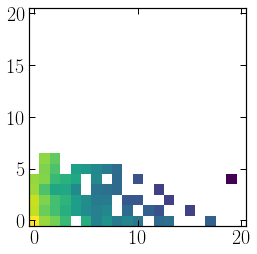

In [631]:
imshow(np.log10(np.abs(S_mwlmc[:,:,0].T)), origin='lower')

In [559]:
S_mw_wake = np.copy(S_mw)
T_mw_wake = np.copy(T_mw)
S_mw_wake[0,0,0] = 0
T_mw_wake[0,0,0] = 0

S_mw_ref = np.zeros(shape(S_mw))
T_mw_ref = np.zeros(shape(T_mw))
S_mw_ref[:,0,0] = S_mw[:,0,0]
T_mw_ref[:,0,0] = T_mw[:,0,0]
## almc + awake

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


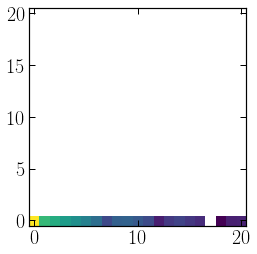

In [560]:
imshow(np.log10(np.abs(S_mw_ref[:,:,0].T)), origin='lower')

In [565]:
G_gadget = 43007.1
rs = 40.85
a1 = biff.gradient(xyz, S_mw_wake, T_mw_wake, G=G_gadget, M=1, r_s=rs)
rho = biff.density(xyz, S_mw, T_mw, M=1, r_s=rs)
rho_wake = biff.density(xyz, S_mw_wake, T_mw_wake, M=1, r_s=rs)
rho_ref = biff.density(xyz, S_mw_ref, T_mw_ref, M=1, r_s=rs)

In [609]:
rho_lmc = biff.density(xyz_shift, S_lmc, T_lmc, M=1, r_s=10)
a_lmc = biff.gradient(xyz_shift, S_lmc, T_lmc, M=1, G=G_gadget, r_s=10)

In [632]:
rho_mwlmc = biff.density(xyz, S_mwlmc, T_mwlmc, M=1, r_s=10)
a_mwlmc = biff.gradient(xyz, S_mwlmc, T_mwlmc, M=1, G=G_gadget, r_s=10)

In [633]:
ax = a1[:,0]
ay = a1[:,1]
az = a1[:,2]

axlmc = a_lmc[:,0]
aylmc = a_lmc[:,1]
azlmc = a_lmc[:,2]

axmwlmc = a_mwlmc[:,0]
aymwlmc = a_mwlmc[:,1]
azmwlmc = a_mwlmc[:,2]

In [634]:
ar, at, ap = Cuadrant4.vel_cartesian_to_galactic(xyz, a1)
ar_lmc, at_lmc, ap_lmc = Cuadrant4.vel_cartesian_to_galactic(xyz, a_lmc)
ar_mwlmc, at_mwlmc, ap_mwlmc = Cuadrant4.vel_cartesian_to_galactic(xyz, a_mwlmc)

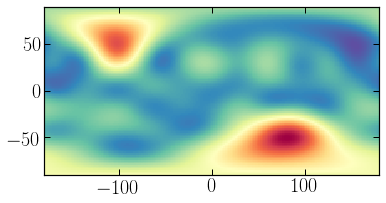

In [637]:
imshow(((rho_mwlmc)).reshape(100, 200), extent=[-180, 180, -90, 90], 
                 cmap='Spectral_r', origin='lower')

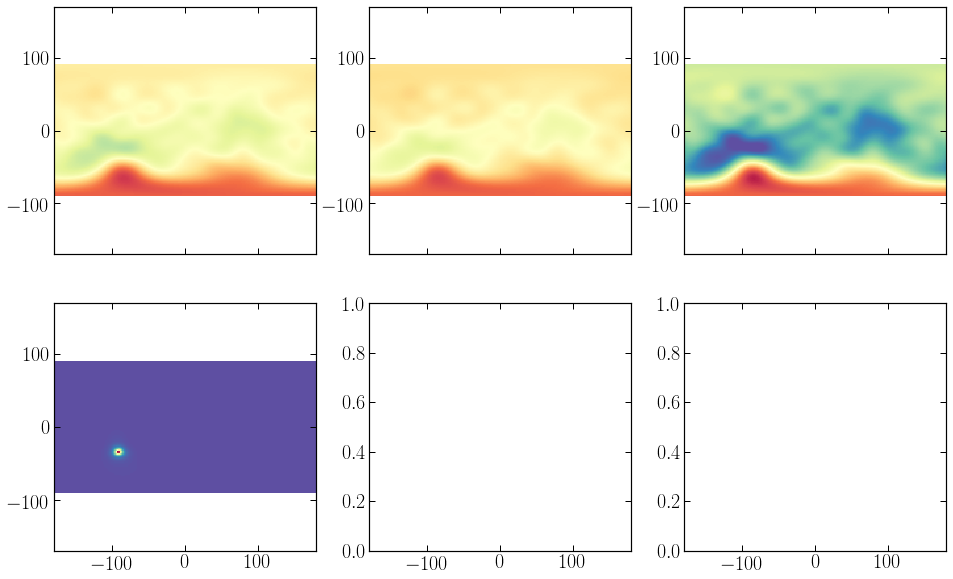

In [608]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10), sharex=True)
im1=ax[0][0].imshow(((rho-rho_ref)/rho_ref).reshape(100, 200), extent=[-180, 180, -90, 90], 
                 cmap='Spectral_r', origin='lower', vmin=-0.3, vmax=0.3)
im2=ax[0][1].imshow((rho_wake).reshape(100, 200), extent=[-180, 180, -90, 90], cmap='Spectral_r', origin='lower',
                vmin=-1E-5, vmax=1E-5)

im2=ax[0][2].imshow((rho).reshape(100, 200), extent=[-180, 180, -90, 90], cmap='Spectral_r', origin='lower',
                vmin=2.5E-5, vmax=3.5E-5)

im1=ax[1][0].imshow(((rho+rho_lmc)/rho_ref).reshape(100, 200), extent=[-180, 180, -90, 90], 
                 cmap='Spectral_r', origin='lower')

#fig.colorbar(im1)
#fig.colorbar(im2)
#axvline(90, c='w', ls=':')

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


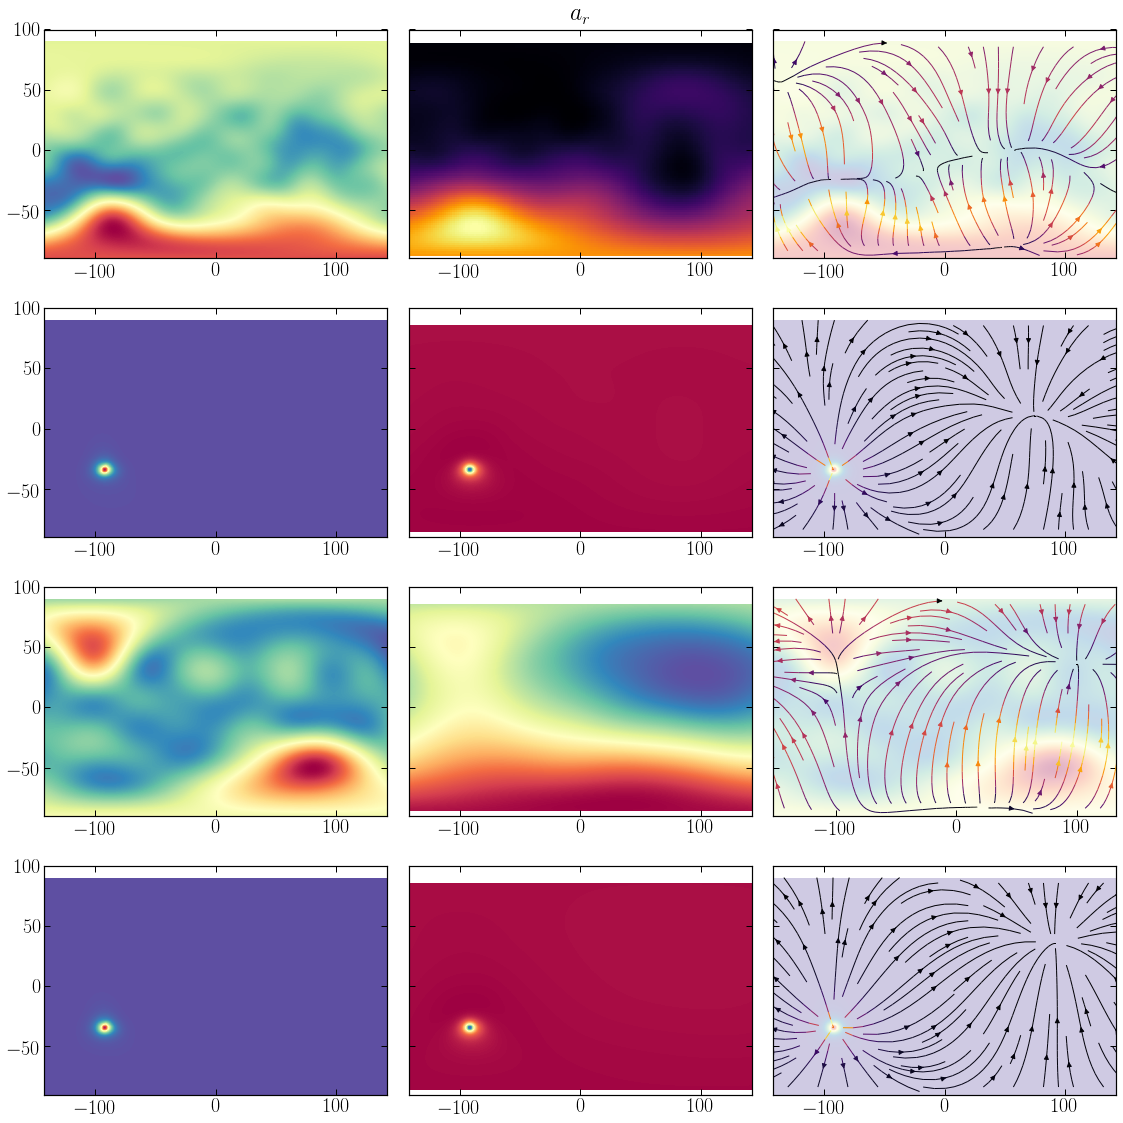

In [641]:

atan = np.sqrt(at.reshape(100,200)**2 + ap.reshape(100,200)**2)
atan_lmc = np.sqrt(at_lmc.reshape(100,200)**2 + ap_lmc.reshape(100,200)**2)
atan_mwlmc = np.sqrt(at_mwlmc.reshape(100,200)**2 + ap_mwlmc.reshape(100,200)**2)

fig, ax = plt.subplots(4, 3, figsize=(16, 16), sharey=True)

im1 = ax[0][0].imshow(rho.reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], cmap='Spectral_r', interpolation='Gaussian')
#fig.colorbar(im1, orientation='horizontal')#
ax[0][1].set_title('$a_r$')
im2 = ax[0][1].imshow(ar.reshape(100, 200),  origin='lower', extent=[-180, 180, -90, 90], cmap='inferno')
#fig.colorbar(im2, orientation='horizontal')


ax[0][2].imshow(rho.reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], 
             cmap='Spectral_r', interpolation='Gaussian', alpha=0.3)

ax[0][2].streamplot(L4, B4, ap.reshape(100, 200), at.reshape(100, 200), color=atan, linewidth=1, cmap=plt.cm.inferno)
#colorbar(orientation='horizontal')


ax[1][0].imshow((rho+rho_lmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], 
             cmap='Spectral_r', interpolation='Gaussian')

ax[1][1].imshow((ar+ar_lmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], cmap='Spectral_r', interpolation='Gaussian')


ax[1][2].imshow((rho+rho_lmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], 
             cmap='Spectral_r', interpolation='Gaussian', alpha=0.3)
ax[1][2].streamplot(L4, B4, (ap+ap_lmc).reshape(100, 200), (at+at_lmc).reshape(100, 200), color=atan_lmc+atan,
                    linewidth=1, cmap=plt.cm.inferno)

ax[2][0].imshow((rho_mwlmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], 
             cmap='Spectral_r', interpolation='Gaussian')

ax[2][1].imshow((ar_mwlmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], cmap='Spectral_r', interpolation='Gaussian')


ax[2][2].imshow((rho_mwlmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], 
             cmap='Spectral_r', interpolation='Gaussian', alpha=0.3)
ax[2][2].streamplot(L4, B4, (ap_mwlmc).reshape(100, 200), (at_mwlmc).reshape(100, 200), color=atan_mwlmc,
                    linewidth=1, cmap=plt.cm.inferno)


ax[3][0].imshow((rho_mwlmc+rho_lmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], 
             cmap='Spectral_r', interpolation='Gaussian')

ax[3][1].imshow((ar_mwlmc+ar_lmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], cmap='Spectral_r', interpolation='Gaussian')


ax[3][2].imshow((rho_mwlmc+rho_lmc).reshape(100, 200), origin='lower', extent=[-180, 180, -90, 90], 
             cmap='Spectral_r', interpolation='Gaussian', alpha=0.3)
ax[3][2].streamplot(L4, B4, (ap_mwlmc+ap_lmc).reshape(100, 200), (at_mwlmc+at_lmc).reshape(100, 200), 
                    color=atan_mwlmc+atan_lmc,
                    linewidth=1, cmap=plt.cm.inferno)


fig.tight_layout()


In [622]:
atan_lmc

array([[71.0628106 , 71.0628106 , 71.0628106 , ..., 71.0628106 ,
        71.0628106 , 71.0628106 ],
       [71.08508448, 71.23826014, 71.39174787, ..., 70.78027378,
        70.93237251, 71.08508448],
       [70.97600757, 71.28204369, 71.58981312, ..., 70.37028535,
        70.67199438, 70.97600757],
       ...,
       [ 9.84322119,  9.87245269,  9.90165565, ...,  9.78478842,
         9.81399013,  9.84322119],
       [ 9.8140727 ,  9.82867511,  9.84325555, ...,  9.78486023,
         9.7994629 ,  9.8140727 ],
       [ 9.79441523,  9.79441523,  9.79441523, ...,  9.79441523,
         9.79441523,  9.79441523]])

In [456]:
def grid(box_size, nbins):
    y_grid = np.linspace(-box_size/2., box_size/2., nbins)
    z_grid = np.linspace(-box_size/2., box_size/2., nbins)
    nbins = len(y_grid)
    y_grid, z_grid = np.meshgrid(y_grid, z_grid)
    
    return y_grid, z_grid, nbins

def bfe_a_grid(S1, T1, y_grid, z_grid, rs):
    xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                             y_grid.flatten(),
                                             z_grid.flatten()]).T)
    a = biff.gradient(xyz, S1, T1, M=1, r_s=rs, G=1)
    a_mw = (a[:,0]**2 + a[:,1]**2 + a[:,2]**2)**0.5
    return a_mw

def bfe_rho_grid(S1, T1, y_grid, z_grid, rs, shift=0):
    xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                             y_grid.flatten(),
                                             z_grid.flatten()]).T)
    if shift==1:
        xyz = spherical_grid_shift(xyz, [-1.6172733999999993, -41.39907439, -27.93125875])
    rho = biff.density(xyz, S1, T1, M=1, r_s=rs)
    return rho

In [561]:
ygr, zgr, _ = grid(300, 300)
rho_wake = bfe_rho_grid(S_mw_wake, T_mw_wake, ygr, zgr, 40.85)
rho_MW = bfe_rho_grid(S_mw, T_mw, ygr, zgr, 40.85)

rho_0 = bfe_rho_grid(S_mw_ref, T_mw_ref, ygr, zgr, 40.85)

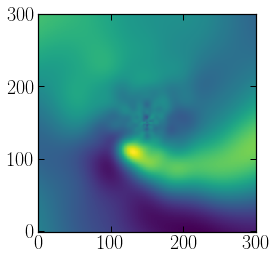

In [562]:
imshow(((rho_MW-rho_0)/rho_0).reshape(_,_), origin='lower')

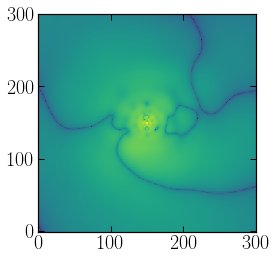

In [563]:
imshow(np.log10(np.abs(rho_wake)).reshape(_,_), origin='lower')

NameError: name 'r_lmc_1' is not defined

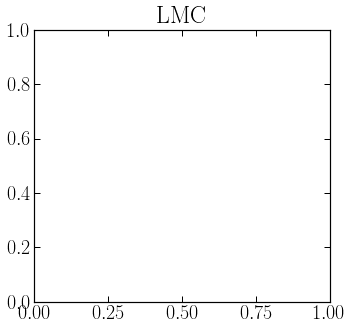

In [584]:
fig = figure(figsize=(18,5))

subplot(1, 3, 1)
title('LMC')
plot(r_lmc_1, a_r_lmc_1/a_r_mw_1+1, c=colors[0], label='1')
plot(r_lmc_2, a_r_lmc_2/a_r_mw_2+1, c=colors[1], label='2')
plot(r_lmc_3, a_r_lmc_3/a_r_mw_3+1, c=colors[2], label='3')
plot(r_lmc_4, a_r_lmc_4/a_r_mw_4+1, c=colors[3], label='4')
plot(r_lmc_5, a_r_lmc_5/a_r_mw_5+1, c=colors[4], label='5')
plot(r_lmc_6, a_r_lmc_6/a_r_mw_6+1, c=colors[5], label='6')
plot(r_lmc_7, a_r_lmc_7/a_r_mw_7+1, c=colors[6], label='7')
plot(r_lmc_8, a_r_lmc_8/a_r_mw_8+1, c=colors[7], label='8')

axvline(50, c='k', ls=':')
xlim(0, 300)
xlabel('r[kpc]')
ylabel('$a_{lmc}/a_{monopole}$')
legend(bbox_to_anchor=(4, 1.05))

subplot(1, 3, 2)
title('LMC Debris')
plot(r_debris_1, a_r_debris1/a_r_wake1, c=colors[0])
plot(r_debris_2, a_r_debris2/a_r_wake2, c=colors[1])
plot(r_debris_3, a_r_debris3/a_r_wake3, c=colors[2])
plot(r_debris_4, a_r_debris4/a_r_wake4, c=colors[3])
plot(r_debris_5, a_r_debris5/a_r_wake5, c=colors[4])
plot(r_debris_6, a_r_debris6/a_r_wake6, c=colors[5])
plot(r_debris_7, a_r_debris7/a_r_wake7, c=colors[6])
plot(r_debris_8, a_r_debris8/a_r_wake8, c=colors[7])
xlim(0, 300)
xlabel('r[kpc]')
ylabel('$a_{mw+lmc\ debris}/a_{mw}$')

subplot(1, 3, 3)
title('Wake')
plot(r_wake_1, a_r_wake1/a_r_mw_1, c=colors[0])
plot(r_wake_2, a_r_wake2/a_r_mw_2, c=colors[1])
plot(r_wake_3, a_r_wake3/a_r_mw_3, c=colors[2])
plot(r_wake_4, a_r_wake4/a_r_mw_4, c=colors[3])
plot(r_wake_5, a_r_wake5/a_r_mw_5, c=colors[4])
plot(r_wake_6, a_r_wake6/a_r_mw_6, c=colors[5])
plot(r_wake_7, a_r_wake7/a_r_mw_7, c=colors[6])
plot(r_wake_8, a_r_wake8/a_r_mw_8, c=colors[7])
text(58, 1.07, 'Transient')
text(200, 1.06, 'Collective')

xlim(0, 300)
xlabel('r[kpc]')
ylabel('$a_{mw}/a_{monopole}$')

#ylim(0, 1.1)
#savefig('a_wake_lmc_debris_octants.pdf', bbox_inches='tight')


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: inval

Text(0,0.5,'$\\Delta a$')

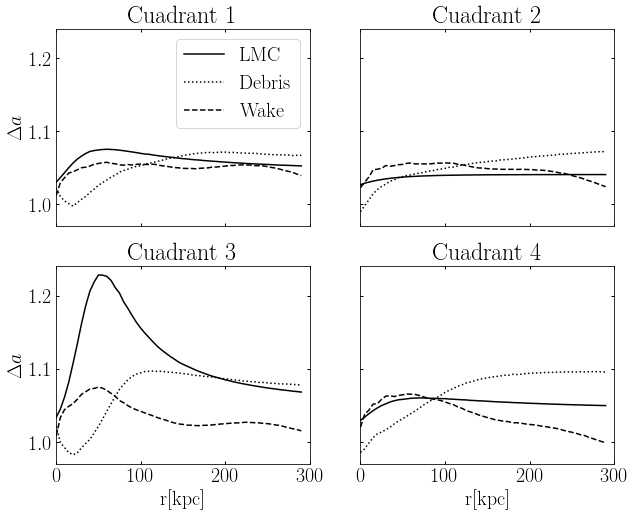

In [87]:
fig, ax = subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

ax[0][0].set_title('Cuadrant 1')
ax[0][0].plot(r_lmc_c1, a_r_lmc_c1/a_r_mw_c1+1, label='LMC', c='k')
ax[0][0].plot(r_debris_c1, a_r_debrisc1/a_r_wakec1, label='Debris', c='k', alpha=1, ls=':')
ax[0][0].plot(r_wake_c1, a_r_wakec1/a_r_mw_c1, label='Wake', c='k', ls='--')
ax[0][0].legend()

ax[0][1].set_title('Cuadrant 2')
ax[0][1].plot(r_lmc_c2, a_r_lmc_c2/a_r_mw_c2+1, label='LMC', c='k')
ax[0][1].plot(r_debris_c2, a_r_debrisc2/a_r_wakec2, label='Debris', c='k', alpha=1, ls=':')
ax[0][1].plot(r_wake_c2, a_r_wakec2/a_r_mw_c2, label='Wake', c='k', ls='--')

ax[1][0].set_title('Cuadrant 3')
ax[1][0].plot(r_lmc_c3, a_r_lmc_c3/a_r_mw_c3+1, label='LMC', c='k')
ax[1][0].plot(r_debris_c3, a_r_debrisc3/a_r_wakec3, label='Debris', c='k', alpha=1, ls=':')
ax[1][0].plot(r_wake_c3, a_r_wakec3/a_r_mw_c3, label='Wake', c='k', ls='--')

ax[1][1].set_title('Cuadrant 4')
ax[1][1].plot(r_lmc_c4, a_r_lmc_c4/a_r_mw_c4+1, label='LMC', c='k')
ax[1][1].plot(r_debris_c4, a_r_debrisc4/a_r_wakec4, label='Debris', c='k', alpha=1, ls=':')
ax[1][1].plot(r_wake_c4, a_r_wakec4/a_r_mw_c4, label='Wake', c='k', ls='--')





#axvline(50, c='k', ls=':')
for i in range(2):
    ax[1][i].set_xlabel('r[kpc]')
    ax[0][i].set_xlim(0, 300)
    ax[1][i].set_xlim(0, 300)
    #ax[1][i].set_xticks([np.arange(0, 300, 50)])

ax[0][0].set_ylabel('$\Delta a$')
ax[1][0].set_ylabel('$\Delta a$')

In [172]:
colors =  plt.cm.Vega20b( (2*np.arange(3)).astype(int) )

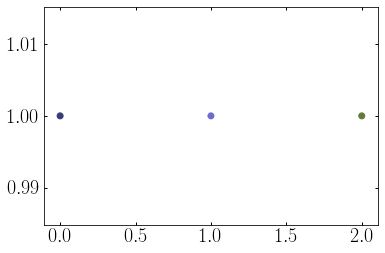

In [173]:
scatter(np.arange(3), np.ones(3), c=colors)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/us

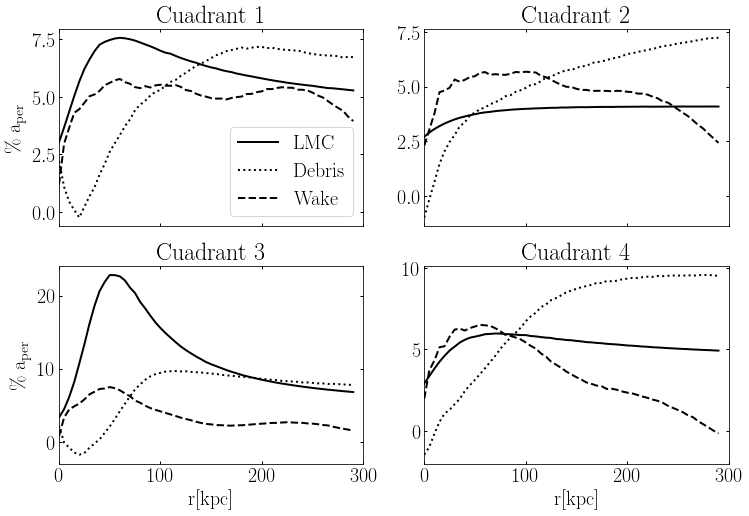

In [186]:
fig, ax = subplots(2, 2, figsize=(12,8), sharex=True)
ax[0][0].set_title('Cuadrant 1')
ax[0][0].plot(r_lmc_c1, ((a_r_lmc_c1/a_r_mw_c1+1)-1)*100, label='LMC', c='k', lw=2)
ax[0][0].plot(r_debris_c1, 100*((a_r_debrisc1/a_r_wakec1)-1), label='Debris', c='k', alpha=1, ls=':', lw=2)
ax[0][0].plot(r_wake_c1, 100*((a_r_wakec1/a_r_mw_c1)-1), label='Wake', c='k', ls='--', lw=2)
ax[0][0].legend()

ax[0][1].set_title('Cuadrant 2')
ax[0][1].plot(r_lmc_c2, ((a_r_lmc_c2/a_r_mw_c2+1)-1)*100, label='LMC', c='k', lw=2)
ax[0][1].plot(r_debris_c2, 100*((a_r_debrisc2/a_r_wakec2)-1), label='Debris', c='k', alpha=1, ls=':', lw=2)
ax[0][1].plot(r_wake_c2, 100*((a_r_wakec2/a_r_mw_c2)-1), label='Wake', c='k', ls='--', lw=2)

ax[1][0].set_title('Cuadrant 3')
ax[1][0].plot(r_lmc_c3, ((a_r_lmc_c3/a_r_mw_c3+1)-1)*100, label='LMC', c='k', lw=2)
ax[1][0].plot(r_debris_c3, 100*((a_r_debrisc3/a_r_wakec3)-1), label='Debris', c='k', alpha=1, ls=':', lw=2)
ax[1][0].plot(r_wake_c3, 100*((a_r_wakec3/a_r_mw_c3)-1), label='Wake', c='k', ls='--', lw=2)

ax[1][1].set_title('Cuadrant 4')
ax[1][1].plot(r_lmc_c4, ((a_r_lmc_c4/a_r_mw_c4+1)-1)*100, label='LMC', c='k', lw=2)
ax[1][1].plot(r_debris_c4, 100*((a_r_debrisc4/a_r_wakec4)-1), label='Debris', c='k', alpha=1, ls=':', lw=2)
ax[1][1].plot(r_wake_c4, 100*((a_r_wakec4/a_r_mw_c4)-1), label='Wake', c='k', ls='--', lw=2)

for i in range(2):
    ax[1][i].set_xlabel('r[kpc]')
    ax[i][0].set_ylabel(r'$\rm{\%\ a_{per}}$')
    ax[0][i].set_xlim(0, 300)
    ax[1][i].set_xlim(0, 300)
    
savefig('acceleration_contribution.pdf', bbox_inches='tight')

In [177]:
#fig = figure(figsize=(6,5))
fig, ax = subplots(2, 4, figsize=(10,8), sharex=True, sharey=True)

ax[0][0].plot(r_lmc_1, a_r_lmc_1/a_r_mw_1+1, label='LMC', c='k')
ax[0][0].plot(r_debris_1, a_r_debris1/a_r_wake1, label='Debris', c='k', alpha=0.7, ls=':')
ax[0][0].plot(r_wake_1, a_r_wake1/a_r_mw_1, label='Wake', c='k', ls='--')
ax[0][0].legend()


ax[0][1].plot(r_lmc_2, a_r_lmc_2/a_r_mw_2+1, label='LMC', c='k')
ax[0][1].plot(r_debris_2, a_r_debris2/a_r_wake2, label='Debris', c='k', alpha=0.7, ls=':')
ax[0][1].plot(r_wake_2, a_r_wake2/a_r_mw_2, label='Wake', c='k', ls='--')

ax[0][2].plot(r_lmc_3, a_r_lmc_3/a_r_mw_3+1, label='LMC', c='k')
ax[0][2].plot(r_debris_3, a_r_debris3/a_r_wake3, label='Debris', c='k', alpha=0.7, ls=':')
ax[0][2].plot(r_wake_3, a_r_wake3/a_r_mw_3, label='Wake', c='C0', ls='--')

ax[0][3].plot(r_lmc_4, a_r_lmc_4/a_r_mw_4+1, label='LMC', c='k')
ax[0][3].plot(r_debris_4, a_r_debris4/a_r_wake4, label='Debris', c='k', alpha=0.7, ls=':')
ax[0][3].plot(r_wake_4, a_r_wake4/a_r_mw_4, label='Wake', c='k', ls='--')


ax[1][0].plot(r_lmc_5, a_r_lmc_5/a_r_mw_5+1, label='LMC', c='k')
ax[1][0].plot(r_debris_5, a_r_debris5/a_r_wake5, label='Debris', c='k', alpha=0.7, ls=':')
ax[1][0].plot(r_wake_5, a_r_wake5/a_r_mw_5, label='Wake', c='k', ls='--')

ax[1][1].plot(r_lmc_6, a_r_lmc_6/a_r_mw_6+1, label='LMC', c='k')
ax[1][1].plot(r_debris_6, a_r_debris6/a_r_wake6, label='Debris', c='k', alpha=0.7, ls=':')
ax[1][1].plot(r_wake_6, a_r_wake6/a_r_mw_6, label='Wake', c='k', ls='--')

ax[1][2].plot(r_lmc_7, a_r_lmc_7/a_r_mw_7+1, label='LMC', c='k')
ax[1][2].plot(r_debris_7, a_r_debris7/a_r_wake7, label='Debris', c='k', alpha=0.7, ls=':')
ax[1][2].plot(r_wake_7, a_r_wake7/a_r_mw_7, label='Wake', c='C0', ls='--')

ax[1][3].plot(r_lmc_8, a_r_lmc_8/a_r_mw_8+1, label='LMC', c='k')
ax[1][3].plot(r_debris_8, a_r_debris8/a_r_wake8, label='Debris', c='k', alpha=0.7, ls=':')
ax[1][3].plot(r_wake_8, a_r_wake8/a_r_mw_8, label='Wake', c='k', ls='--')




#axvline(50, c='k', ls=':')
for i in range(4):
    ax[1][i].set_xlabel('r[kpc]')
    ax[0][i].set_xlim(0, 300)
    ax[1][i].set_xlim(0, 300)
    ax[1][i].set_xticks([np.arange(0, 300, 50)])

ax[0][0].set_ylabel('$\Delta a$')
ax[1][0].set_ylabel('$\Delta a$')

#savefig('a_wake_lmc_debris_octants.pdf', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: inval

Text(0,0.5,'$\\Delta a$')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fafd3028048> (for post_execute):


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [21]:
def grid(box_size, nbins):
    y_grid = np.linspace(-box_size/2., box_size/2., nbins)
    z_grid = np.linspace(-box_size/2., box_size/2., nbins)
    nbins = len(y_grid)
    y_grid, z_grid = np.meshgrid(y_grid, z_grid)
    
    return y_grid, z_grid, nbins

def bfe_a_grid(S1, T1, y_grid, z_grid, rs):
    xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                             y_grid.flatten(),
                                             z_grid.flatten()]).T)
    a = biff.gradient(xyz, S1, T1, M=1, r_s=rs, G=1)
    a_mw = (a[:,0]**2 + a[:,1]**2 + a[:,2]**2)**0.5
    return a_mw

def bfe_rho_grid(S1, T1, y_grid, z_grid, rs, shift=0):
    xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                             y_grid.flatten(),
                                             z_grid.flatten()]).T)
    if shift==1:
        xyz = spherical_grid_shift(xyz, [-1.6172733999999993, -41.39907439, -27.93125875])
    rho = biff.density(xyz, S1, T1, M=1, r_s=rs)
    return rho

In [22]:
ygr, zgr, _ = grid(400, 100)
a_wake = bfe_a_grid(S_mw_wake, T_mw_wake, ygr, zgr, 40.85)
rho_wake = bfe_rho_grid(S_mw_wake, T_mw_wake, ygr, zgr, 40.85)
#rho_wake2 = bfe_rho_grid(S_mw/S_mw_ref, T_mw/T_mw_ref, ygr, zgr, 40.85)

In [23]:
a_mw = bfe_a_grid(S_mw, T_mw, ygr, zgr, 40.85)
a_mw_ref = bfe_a_grid(S_mw_ref, T_mw_ref, ygr, zgr, 40.85)

rho_mw = bfe_rho_grid(S_mw, T_mw, ygr, zgr, 40.85)
rho_mw_ref = bfe_rho_grid(S_mw_ref, T_mw_ref, ygr, zgr, 40.85)

In [24]:
rho_mwf = bfe_rho_grid(S_mwlmc, T_mwlmc, ygr, zgr, 40.85)
rho_lmc = bfe_rho_grid(S_lmc, T_lmc, ygr, zgr, 40.85, shift=1)


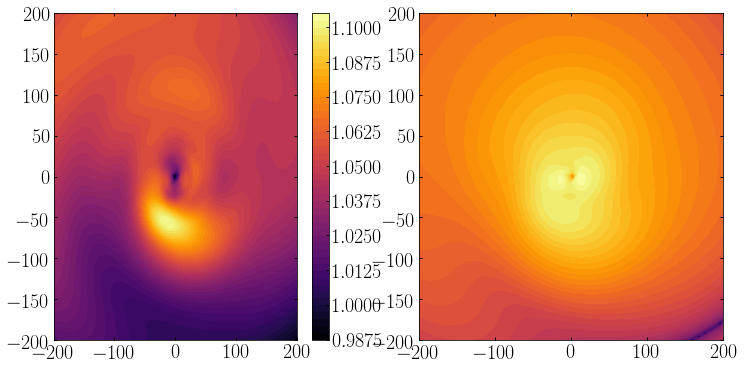

In [25]:
figure(figsize=(12,6))
subplot(1, 2, 1)
contourf(ygr, zgr, ((a_mw/a_mw_ref).reshape(_, _)), 50, cmap='inferno')
colorbar()
subplot(1, 2, 2)
contourf(ygr, zgr, np.log10(np.abs((a_mw-a_mw_ref).reshape(_, _))), 50, cmap='inferno')


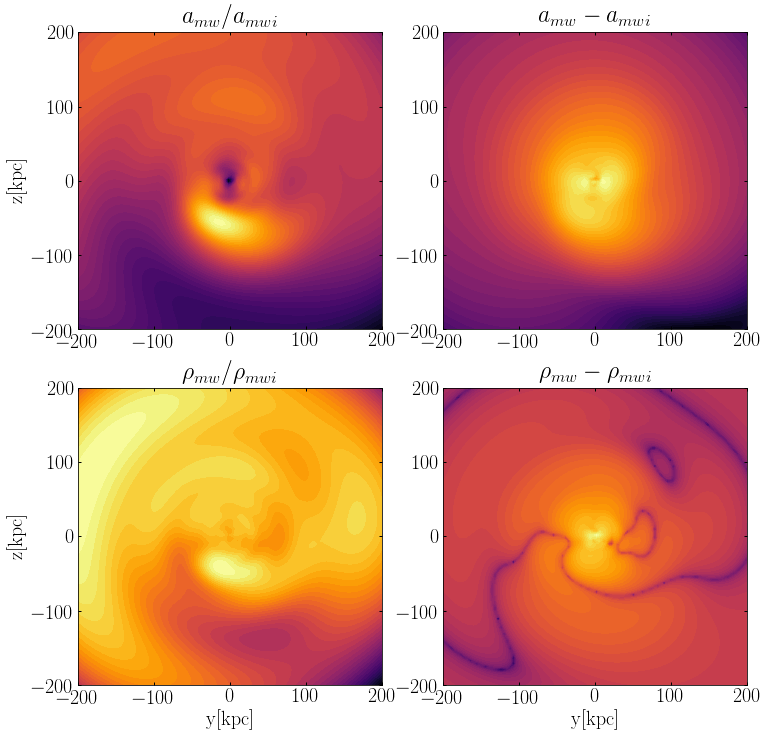

In [33]:
figure(figsize=(12,12))
subplot(2, 2, 1)
title('$a_{mw}/a_{mwi}$')
contourf(ygr, zgr, np.log10(np.abs((a_mw/a_mw_ref).reshape(_, _))), 50, cmap='inferno')
ylabel('z[kpc]')


subplot(2, 2, 2)
title('$a_{mw}-a_{mwi}$')
contourf(ygr, zgr, np.log10(np.abs(a_wake.reshape(_, _))), 50, cmap='inferno')


subplot(2, 2, 3)
title(r'$\rho_{mw}/\rho_{mwi}$')
contourf(ygr, zgr, np.log10(np.abs((rho_mw/rho_mw_ref).reshape(_, _))), 50, cmap='inferno')
xlabel('y[kpc]')
ylabel('z[kpc]')


subplot(2, 2, 4)
title(r'$\rho_{mw}-\rho_{mwi}$')
contourf(ygr, zgr, np.log10(np.abs((rho_mw-rho_mw_ref).reshape(_, _))), 50, cmap='inferno')
plt.Circle((0,0), radius= 50, color='k')
xlabel('y[kpc]')

savefig('Wake_definition.png', bbox_inches='tight')


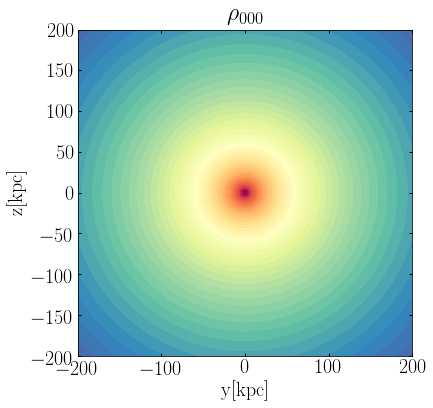

In [73]:
figure(figsize=(6,6))
subplot(1, 1, 1)
title(r'$\rho_{000}$')
contourf(ygr, zgr, np.log10(np.abs((rho_mw_ref).reshape(_, _))), 50
         , cmap='Spectral_r', vmin=-7.2, vmax=-2.3)
#scatter(-41, -28, c='k')
xlabel('y[kpc]')
ylabel('z[kpc]')
savefig('rho_000.pdf', bbox_inches='tight')


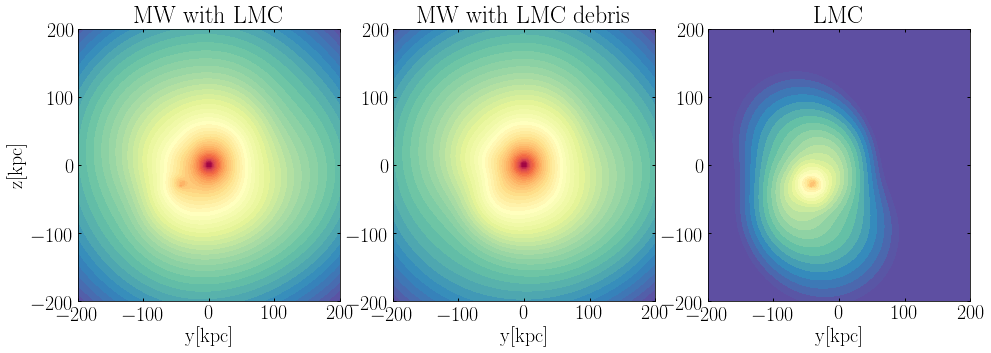

In [38]:
figure(figsize=(16,5))

subplot(1, 3, 1)
title('MW with LMC')
contourf(ygr, zgr, np.log10(np.abs((rho_lmc+rho_mwf).reshape(_, _))), 50
         , cmap='Spectral_r', vmin=-7.2, vmax=-2.3)
#scatter(-41, -28, c='k')
xlabel('y[kpc]')
ylabel('z[kpc]')

subplot(1, 3, 2)
title('MW with LMC debris')

contourf(ygr, zgr, np.log10(np.abs((rho_mwf).reshape(_, _))), 50, cmap='Spectral_r', vmin=-7.2, vmax=-2.3)
xlabel('y[kpc]')

subplot(1, 3, 3)
title('LMC')
contourf(ygr, zgr, np.log10(np.abs((rho_lmc).reshape(_, _))), 50, cmap='Spectral_r', vmin=-7.2, vmax=-2.3)
xlabel('y[kpc]')

savefig('mw_lmc_dens_bfe.pdf', bbox_inches='tight')

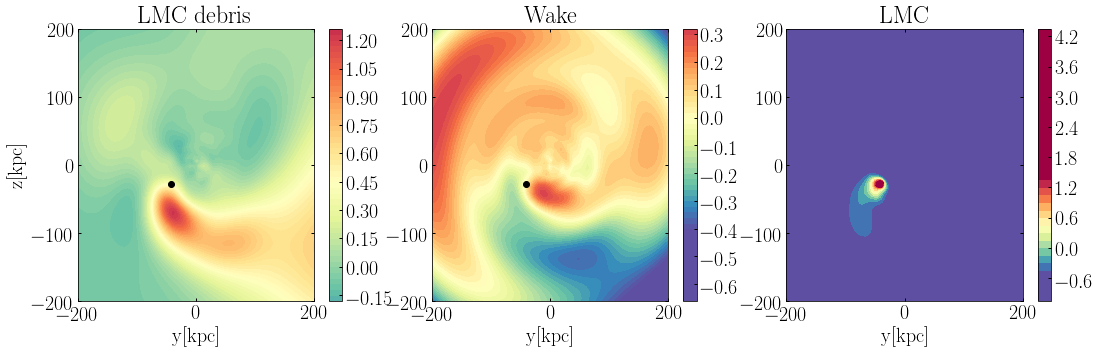

In [75]:
figure(figsize=(18,5))
subplot(1, 3, 1)
title('LMC debris')
contourf(ygr, zgr, (((rho_mwf/rho_mw).reshape(_, _)))-1, 50, cmap='Spectral_r', vmin=-0.5, vmax=1.4)
colorbar()
scatter(-41, -28, c='k')
ylabel('z[kpc]')
xlabel('y[kpc]')

subplot(1, 3, 2)
title('Wake')
contourf(ygr, zgr, (((rho_mw/rho_mw_ref).reshape(_, _)))-1, 50, cmap='Spectral_r', vmin=-0.4, vmax=0.4)
colorbar()
scatter(-41, -28, c='k')
xlabel('y[kpc]')


subplot(1, 3, 3)
title('LMC')
contourf(ygr, zgr, (((rho_lmc/rho_mw_ref).reshape(_, _)))-1, 50, cmap='Spectral_r', vmin=-0.5, vmax=1.4)
colorbar()
#scatter(-41, -28, c='k')
xlabel('y[kpc]')
savefig('dens_components.png', bbox_inches='tight')

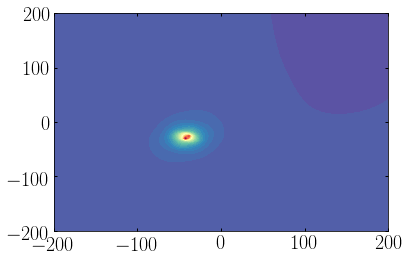

In [37]:
contourf(ygr, zgr, (((rho_lmc).reshape(_, _)))-1, 50, cmap='Spectral_r')


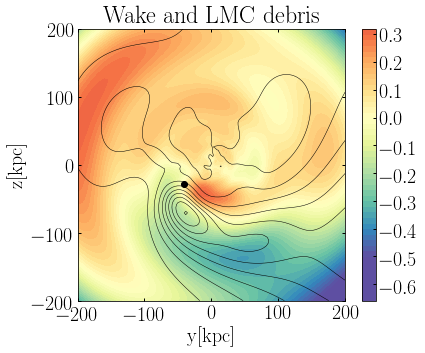

In [32]:
figure(figsize=(6,5))
title('Wake and LMC debris')
contourf(ygr, zgr, (rho_mw/rho_mw_ref).reshape(_, _)-1, 50, cmap='Spectral_r', vmin=-0.5, vmax=0.5)
colorbar()
contour(ygr, zgr, ((rho_mwf/rho_mw).reshape(_, _))-1, 10, vmin=-0.5, vmax=0.5, 
        colors='k', linewidths=0.5)
scatter(-41, -28, c='k')

xlabel('y[kpc]')
ylabel('z[kpc]')
savefig('wake_lmc_debris.png', bbox_inches='tight')

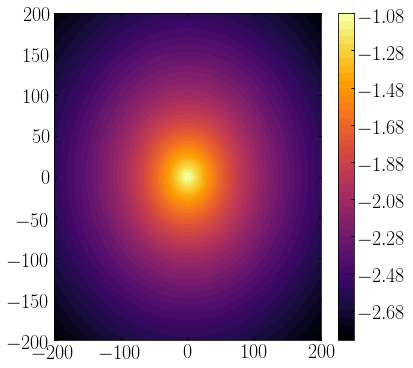

In [17]:
figure(figsize=(6,6))
contourf(ygr, zgr, np.log10(np.abs(a_mw.reshape(_, _))), 50, cmap='inferno')
colorbar()

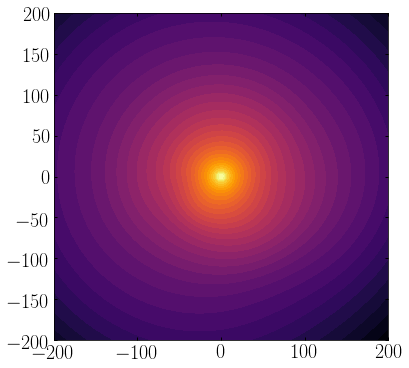

In [31]:
figure(figsize=(6,6))
contourf(ygr, zgr, np.log10(np.abs(rho_mw.reshape(_, _))), 50, cmap='inferno')
